# GalaxyMNIST S4 Model Training, Evaluation, and Weight Export (PyTorch Version)

## About GalaxyMNIST

GalaxyMNIST is a dataset of galaxy morphology images designed as an astronomy-specific alternative to traditional benchmark datasets like MNIST. Created by Mike Walmsley and colleagues, it contains 10,000 galaxies from the Galaxy Zoo project, each labeled as one of four morphological types:

- **Smooth Round**: Elliptical galaxies with smooth, featureless light distributions
- **Smooth Cigar**: Elongated elliptical galaxies viewed edge-on
- **Edge-on Disk**: Spiral galaxies viewed edge-on, showing a thin disk structure
- **Unbarred Spiral**: Face-on spiral galaxies with visible spiral arm patterns

Each image is 64×64 pixels with 3 color channels (RGB), derived from SDSS imaging data. The dataset presents a more challenging and scientifically relevant classification task compared to handwritten digits, with real-world astronomical noise, varying brightness scales, and subtle morphological differences.

**References:**
- Walmsley, M., et al. (2022). "Galaxy Zoo DECaLS: Detailed visual morphology measurements from volunteers and deep learning for 314,000 galaxies." *Monthly Notices of the Royal Astronomical Society*, 509(3), 3966-3988.
- GalaxyMNIST Repository: https://github.com/mwalmsley/galaxy_mnist

---

**This notebook** demonstrates training a Structured State Space (S4) model for galaxy morphology classification. We convert RGB images to grayscale, flatten them using a Hilbert curve to preserve spatial locality, and process them as 1D sequences of 4,096 pixels. The S4 architecture's ability to capture long-range dependencies makes it well-suited for this task, achieving competitive performance without traditional convolutional layers.

## Preliminary Setup

Note: Python version 3.11.7 is used in this notebook.

In [1]:
# Check if GPU is available
!nvidia-smi

Tue Feb 24 06:36:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.44                 Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   31C    P8             12W /  170W |     581MiB /  12288MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# If you have a GPU, prefer installing the CUDA version of PyTorch
# Refer to https://pytorch.org/get-started/locally/ for specific instructions.
# For example for CUDA 13.0, you can use the following command:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu130

# For CPU-only installation, you can use the following command:
# %pip install torch torchvision

# Other dependencies
%pip install numpy matplotlib scikit-learn h5py tqdm seaborn torchinfo einops

Looking in indexes: https://download.pytorch.org/whl/cu130
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# GalaxyMNIST is already installed from terminal
# No need to reinstall here
print("✓ GalaxyMNIST package ready")

✓ GalaxyMNIST package ready


In [4]:
# Verify GalaxyMNIST import works
try:
    from galaxy_mnist import GalaxyMNIST
    print("✓ GalaxyMNIST imported successfully")
except ImportError as e:
    print(f"⚠ Import issue: {e}")
    print("Run this in terminal if needed: pip install git+https://github.com/mwalmsley/galaxy_mnist.git@c1fe9853a00bc34b2ff082585c6bb1654d34d239")

✓ GalaxyMNIST imported successfully


## 1. Imports and Configurations

In [5]:
# Standard library
import csv
import random

# Numerical / plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

# Classifier
from model import GalaxyClassifierS4D
from model.functions import export_model_parameters, load_data

from utils import set_pbar_style

In [6]:
set_pbar_style(bar_fill_color="#FFFFFF", text_color="#FFFFFF") # Make progress bars look good in notebooks
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Set device

CLASS_NAMES =  ["Smooth Round", "Smooth Cigar", "Edge-on Disk", "Unbarred Spiral"] # Class names for GalaxyMNIST

# Whether to use colored images
COLORED = False  # Start with grayscale

# Set RNG seeds for reproducibility
# Use your ERP id...
RNG_SEED = 29070 # TODO: Replace with your ERP id for actual experiments

# Set seeds
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
torch.manual_seed(RNG_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(RNG_SEED)

print(f"Using RNG seed: {RNG_SEED}")
print(f"Using device: {DEVICE}")

Using RNG seed: 29070
Using device: cuda


In [7]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500, 
    'figure.autolayout': True, 
    'figure.figsize': [17, 12], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 10, 
    'lines.linewidth': 1.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 15,
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10}

sns.set_theme(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True, 
        rc=rc)

Failed to read module file 'C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0\Lib\_strptime.py' for module '_strptime': UnicodeDecodeError
Traceback (most recent call last):
  File "d:\ammar\.venv\Lib\site-packages\IPython\core\extensions.py", line 62, in load_extension
    return self._load_extension(module_str)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "d:\ammar\.venv\Lib\site-packages\IPython\core\extensions.py", line 77, in _load_extension
    mod = import_module(module_str)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.3312.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py", line 88, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>"

## 2. Load and Preprocess the GalaxyMNIST Dataset

We load the GalaxyMNIST dataset and preprocess it by converting RGB images to grayscale (averaging across channels) and normalizing pixel values to the [0, 1] range. The labels are converted to one-hot encoding for compatibility with the cross-entropy loss function.

In [8]:
X, y_onehot, y = load_data(root="./data", download=True, train=True, colored=COLORED)
NUM_CLASSES = y_onehot.shape[1]

Original Dataset Size: 8000 samples


In [9]:
# Verify the new dataset size
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y_onehot shape: {y_onehot.shape}")
print(f"Number of classes: {NUM_CLASSES}")

X shape: torch.Size([8000, 1, 64, 64])
y shape: torch.Size([8000])
y_onehot shape: torch.Size([8000, 4])
Number of classes: 4


### 2.2 Prepare the Test and Train Datasets

We split the dataset into training (80%) and validation (20%) sets using stratified sampling to maintain class balance. PyTorch DataLoaders are created with a batch size of 64 for efficient mini-batch training.

In [10]:
BATCH_SIZE = 64

# Split into train/validation sets
x_train, x_val, y_train_onehot, y_val_onehot = train_test_split(X, y_onehot, test_size=0.2, random_state=RNG_SEED, stratify=y)

# Create TensorDatasets
train_ds = TensorDataset(x_train, y_train_onehot)
val_ds = TensorDataset(x_val, y_val_onehot)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

### 2.3 Save Sample Images for Later Use in C/RISC-V Programs

We export 100 random training samples to a CSV file for testing inference implementations in lower-level languages. Each row contains the true label followed by the flattened 4,096 pixel values.

In [11]:
# This currently makes a CSV dump. 
# For RISCV programs, it would be better to store it in assembly format
# i.e.
#
# .data
# sample: 
#   .float 0.0, 1.0, 2.0, ...
#   .float ...
#
# TODO: Update this to dump in assembly format if specified

indices = random.sample(range(len(x_train)), 100)

with open("galaxy_samples.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for idx in indices:
        image = x_train[idx].squeeze().numpy()  # (64, 64)
        label = torch.argmax(y_train_onehot[idx]).item()
        row = [label] + image.flatten().tolist()
        writer.writerow(row)

## 3. Visualize GalaxyMNIST Images

### 3.1 Define a Function to Display Images

In [12]:
def plot_galaxy_images(x_data, y_data, num_images=16, colored=False):
    """
    Function to plot a grid of random GalaxyMNIST images with labels.

    Parameters:
    x_data (torch.Tensor): Input images (N,1,64,64)
    y_data (torch.Tensor): Labels (N,) as integer class indices
    num_images (int): Number of images to display
    colored (bool): Whether to plot in color or grayscale
    """
    random_indices = np.random.choice(len(x_data), num_images, replace=False)
    random_images = x_data[random_indices].squeeze().numpy()  # remove channel dim
    random_labels = torch.argmax(y_data[random_indices], dim=1).numpy()

    if num_images == 3:
        rows = 1
        cols = 3
    else:
        cols = int(np.ceil(np.sqrt(num_images)))
        rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.flatten()

    for i in range(num_images):
        if colored:
            # x_data shape for RGB: (N, 3, H, W) → convert to HWC for imshow
            img = random_images[i]
            if img.ndim == 3:  # (C, H, W)
                img = np.transpose(img, (1, 2, 0))
            axes[i].imshow(img)
        else:
            # grayscale: 2D image
            sns.heatmap(random_images[i], ax=axes[i], cmap='magma', cbar=False, xticklabels=False, yticklabels=False)

        axes[i].set_title(CLASS_NAMES[random_labels[i]], fontsize=10)
        axes[i].axis('off')
        
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


### 3.2 Plot Galaxy Samples

Visualize a random selection of galaxy images from the dataset using the Magma colormap, which provides good contrast for astronomical data.

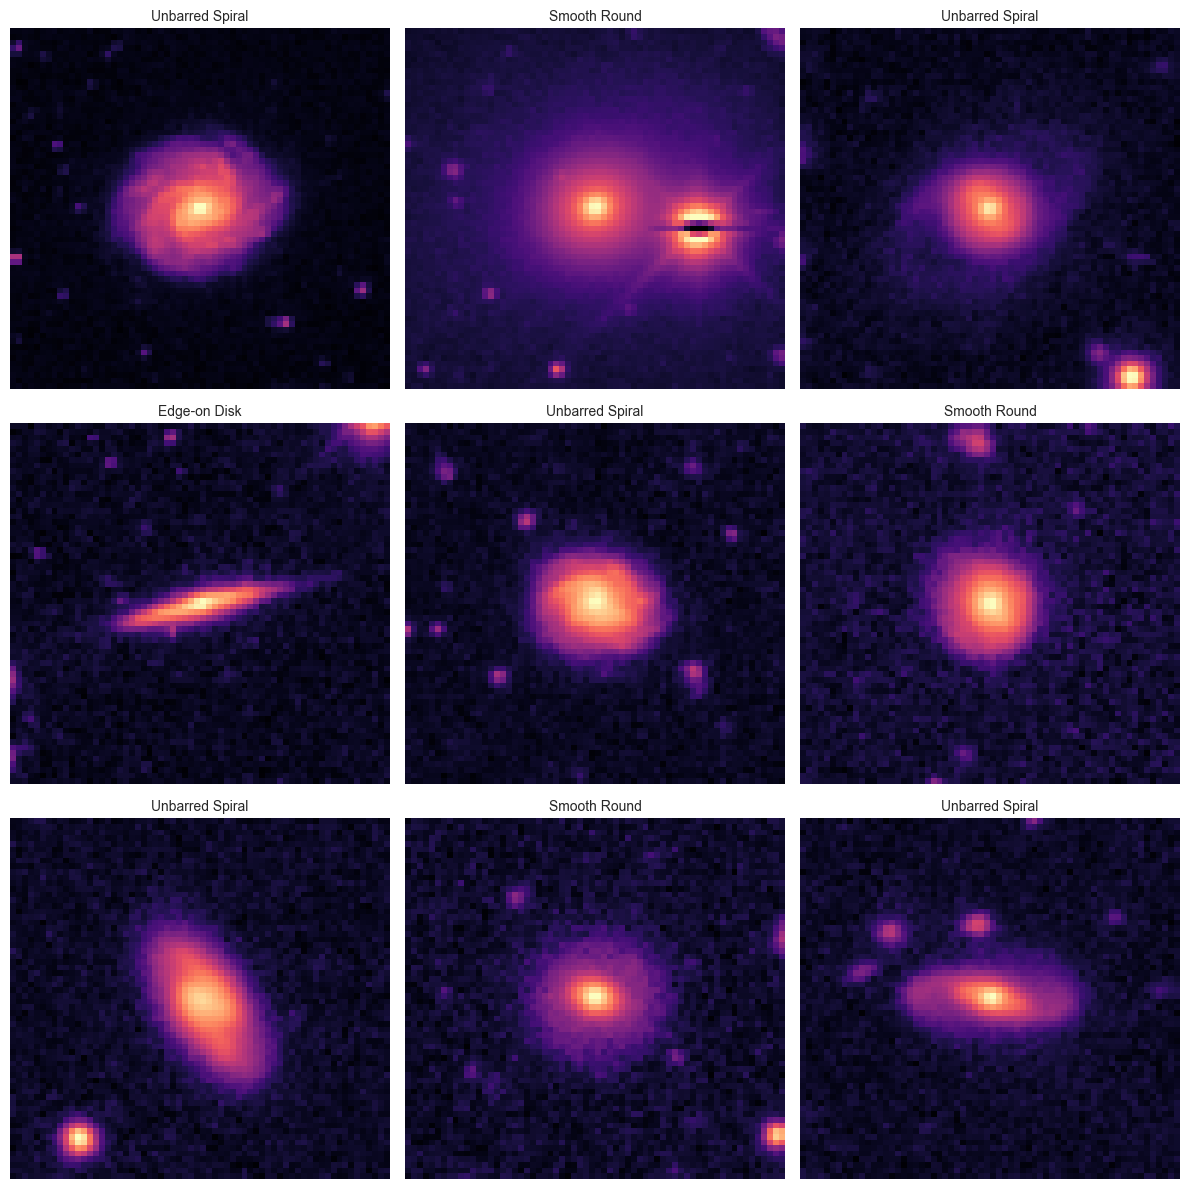

In [13]:
plot_galaxy_images(X, y_onehot, num_images=9, colored=COLORED)

## 4. Build the Structured State Space (S4) Model with Hilbert Curve Scanning

### 4.1 Hilbert Curve Preprocessing

Traditional sequence models process images in row-major order (left-to-right, top-to-bottom), which can disrupt spatial locality—pixels that are spatially close may be far apart in the sequence. The Hilbert curve is a space-filling curve that maps 2D coordinates to 1D while preserving locality: nearby pixels in 2D space remain nearby in the 1D sequence.

For our 64×64 galaxy images, we precompute the Hilbert curve traversal order and store it as a lookup table. This reordering helps the S4 model capture spatial relationships more effectively than naive flattening would.
    
### 4.2 S4 Model Architecture

Our model treats galaxy classification as a sequence modeling problem with the following architecture:

**Input Processing:**
- Input: 64×64 RGB or grayscale galaxy images → $(B, C, 64, 64)$ where $C = 3$ for RGB or $C = 1$ for grayscale
- Hilbert curve scanning → Reordered sequence $(B, 4096, C)$
- Input Projection: Linear layer mapping $C$-dimensional pixel values to model dimension $(B, 4096, d_{model})$

**S4 Sequence Processing:**
We stack two S4D (diagonal state space) layers, each with:
- State dimension: $d_{state} = 64$ (controls the model's memory capacity)
- Model dimension: $d_{model} = 64$ (output feature dimension)
- Activation: GELU after each S4 layer

The S4 layers model the sequential dependencies across the 4,096-pixel sequence, learning to identify morphological patterns that distinguish galaxy types.

**Classification Head:**
- Extract final timestep: Take the last hidden state $(B, 64)$ as the sequence summary
- Fully connected layer: Map to 4 class logits $(B, 4)$
- Softmax layer: Convert logits to probability distribution over classes

**Mathematical Flow:**

$$X_{img} \in \mathbb{R}^{C \times 64 \times 64} \xrightarrow{\text{Hilbert}} X_{seq} \in \mathbb{R}^{4096 \times C}$$

$$X_{seq} \xrightarrow{\text{Linear}} X_{proj} \in \mathbb{R}^{4096 \times 64}$$

$$X_{proj} \xrightarrow{\text{S4D}_1} Z_1 \in \mathbb{R}^{4096 \times 64} \xrightarrow{\text{GELU}} A_1$$

$$A_1 \xrightarrow{\text{S4D}_2} Z_2 \in \mathbb{R}^{4096 \times 64} \xrightarrow{\text{GELU}} A_2$$

$$A_2[:, -1, :] \in \mathbb{R}^{64} \xrightarrow{\text{Linear}} Y_{logits} \in \mathbb{R}^{4} \xrightarrow{\text{Softmax}} Y_{probs}$$

In [14]:
# Instantiate model
model = GalaxyClassifierS4D(num_classes=NUM_CLASSES, colored=COLORED).to(DEVICE)
model_sum = summary(model, input_size=(2, 1 if not COLORED else 3, 64, 64)) # Summarize model
print(model_sum)

Layer (type:depth-idx)                   Output Shape              Param #
GalaxyClassifierS4D                      [2, 4]                    --
├─HilbertScan: 1-1                       [2, 4096, 1]              --
├─Linear: 1-2                            [2, 4096, 64]             128
├─S4D: 1-3                               [2, 4096, 64]             8,320
├─GELU: 1-4                              [2, 4096, 64]             --
├─S4D: 1-5                               [2, 4096, 64]             8,320
├─GELU: 1-6                              [2, 4096, 64]             --
├─TakeLastTimestep: 1-7                  [2, 64]                   --
├─Linear: 1-8                            [2, 4]                    260
├─Softmax: 1-9                           [2, 4]                    --
Total params: 17,028
Trainable params: 17,028
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.03
Forward/backward pass size (MB): 12.58
Params size (MB): 0.07
Estimated Total Size (M

## 5. Compile and Train the Model

We train the model using the Adam optimizer with a learning rate of 0.001 and cross-entropy loss. 

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
loss_fn = nn.CrossEntropyLoss()

# Global training history
# Persistent across training runs
history = {
    "loss": [],
    "val_accuracy": []
}

In [16]:
def train(train_loader, val_loader, model, optimizer, loss_fn, epochs, device, verbose=True):
    """Train the model and validate after each epoch.

    Parameters:
    -----------
    train_loader : DataLoader
        DataLoader for training data.
    val_loader : DataLoader
        DataLoader for validation data.
    model : nn.Module
        The neural network model to train.
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters.
    loss_fn : nn.Module
        Loss function to compute training loss.
    epochs : int
        Number of training epochs.
    device : torch.device
        Device to run the training on (CPU or GPU).

    Returns:
    --------
    history : dict
        Dictionary containing training loss and validation accuracy history.
    """

    history = {
        "loss": [],
        "val_accuracy": []
    }

    ebar = tqdm(range(epochs), desc="Training Progress", disable=verbose)

    # If verbose, don't show outer pbar
    for epoch in ebar:
        model.train()
        running_loss = 0.0

        # show pbar only if verbose
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", disable=not verbose)

        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, return_logits=True)
            loss = loss_fn(outputs, torch.argmax(targets, dim=1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pbar.set_postfix({"Batch Loss": loss.item()})

        epoch_loss = running_loss / len(train_loader)
        history["loss"].append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs, return_logits=True)

                predicted = torch.argmax(outputs, dim=1)
                target = torch.argmax(targets, dim=1)

                correct += (predicted == target).sum().item()
                total += targets.size(0)

        val_accuracy = correct / total
        history["val_accuracy"].append(val_accuracy)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

        ebar.set_postfix({"Loss": epoch_loss, "Val Acc": val_accuracy})

    return history

In [17]:
# Change this to atleast 10 for meaningful training
EPOCHS = 15

train_hist = train(train_loader, val_loader, model, optimizer, loss_fn, EPOCHS, DEVICE, verbose=True)

# append to existing history
# This way keep training history across multiple runs
history["loss"].extend(train_hist["loss"])
history["val_accuracy"].extend(train_hist["val_accuracy"])

Epoch 1/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/15 - Loss: 1.4764 - Val Accuracy: 0.2744


Epoch 2/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 2/15 - Loss: 1.3663 - Val Accuracy: 0.3350


Epoch 3/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 3/15 - Loss: 1.3167 - Val Accuracy: 0.3831


Epoch 4/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 4/15 - Loss: 1.2475 - Val Accuracy: 0.4506


Epoch 5/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 5/15 - Loss: 1.1936 - Val Accuracy: 0.4313


Epoch 6/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 6/15 - Loss: 1.1579 - Val Accuracy: 0.4806


Epoch 7/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 7/15 - Loss: 1.1446 - Val Accuracy: 0.4819


Epoch 8/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 8/15 - Loss: 1.1290 - Val Accuracy: 0.4763


Epoch 9/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9/15 - Loss: 1.0698 - Val Accuracy: 0.5600


Epoch 10/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/15 - Loss: 0.9700 - Val Accuracy: 0.5819


Epoch 11/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 11/15 - Loss: 0.8928 - Val Accuracy: 0.5900


Epoch 12/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12/15 - Loss: 0.8337 - Val Accuracy: 0.6381


Epoch 13/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 13/15 - Loss: 0.8016 - Val Accuracy: 0.6325


Epoch 14/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 14/15 - Loss: 0.7788 - Val Accuracy: 0.6469


Epoch 15/15 - Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 15/15 - Loss: 0.7608 - Val Accuracy: 0.6356


## 6. Evaluate the Model

### 6.1 Plot the Training History

Visualize the training loss curve to assess model convergence and identify potential overfitting or underfitting.

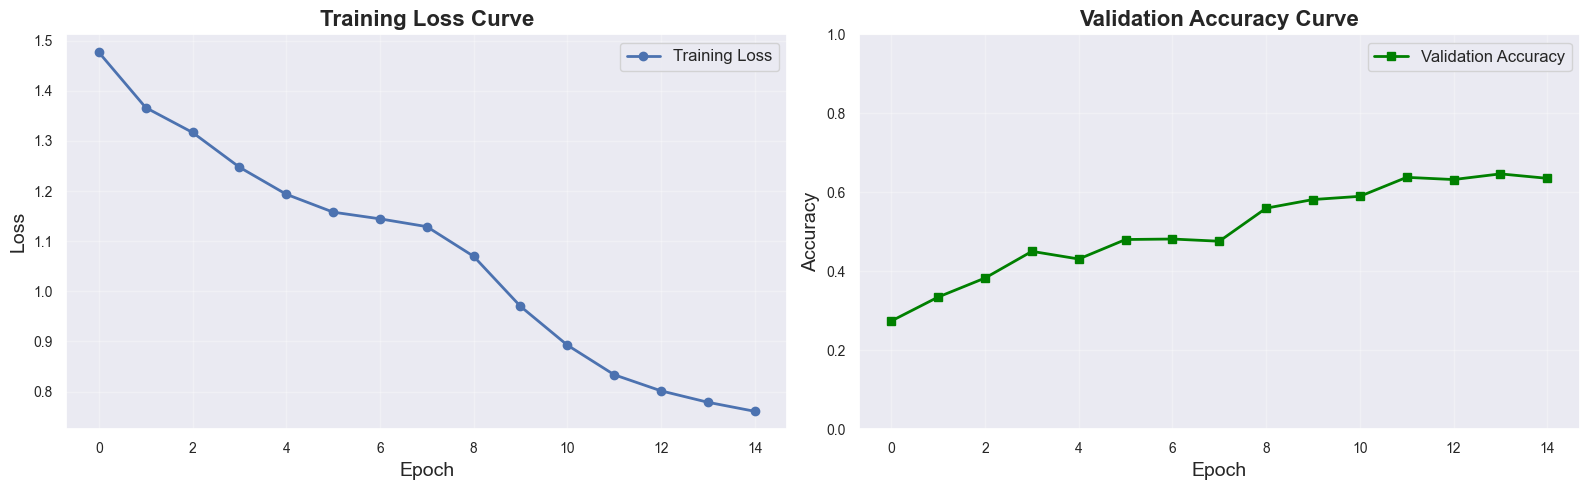

Final Training Loss: 0.7608
Final Validation Accuracy: 0.6356


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot training loss
axes[0].plot(history["loss"], marker='o', linestyle='-', linewidth=2, markersize=6, label='Training Loss')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Loss', fontsize=14)
axes[0].set_title('Training Loss Curve', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot validation accuracy
axes[1].plot(history["val_accuracy"], marker='s', linestyle='-', linewidth=2, markersize=6, color='green', label='Validation Accuracy')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].set_title('Validation Accuracy Curve', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

### 6.2 Evaluate the Model on the Test Set

Compute classification accuracy on the test set to quantify model performance.

#### 6.2.1 Load the Test set

In [19]:
# Load test data (train=False loads the test split)
X_test, y_test_onehot, y_test = load_data(root="./data", download=True, train=False, colored=COLORED)

test_ds = TensorDataset(X_test, y_test_onehot)
test_loader = DataLoader(test_ds, batch_size=64)

Original Dataset Size: 2000 samples


In [20]:
model.eval()

correct = 0
total = 0
all_preds = []
with torch.no_grad():
    for imgs, labels in test_loader:

        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs, return_logits=True)

        preds = torch.argmax(logits, dim=1)
        target = torch.argmax(labels, dim=1)

        correct += (preds == target).sum().item()
        total += labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())

test_accuracy = correct / total
print(f"Validation accuracy: {test_accuracy:.4f}")

Validation accuracy: 0.6420


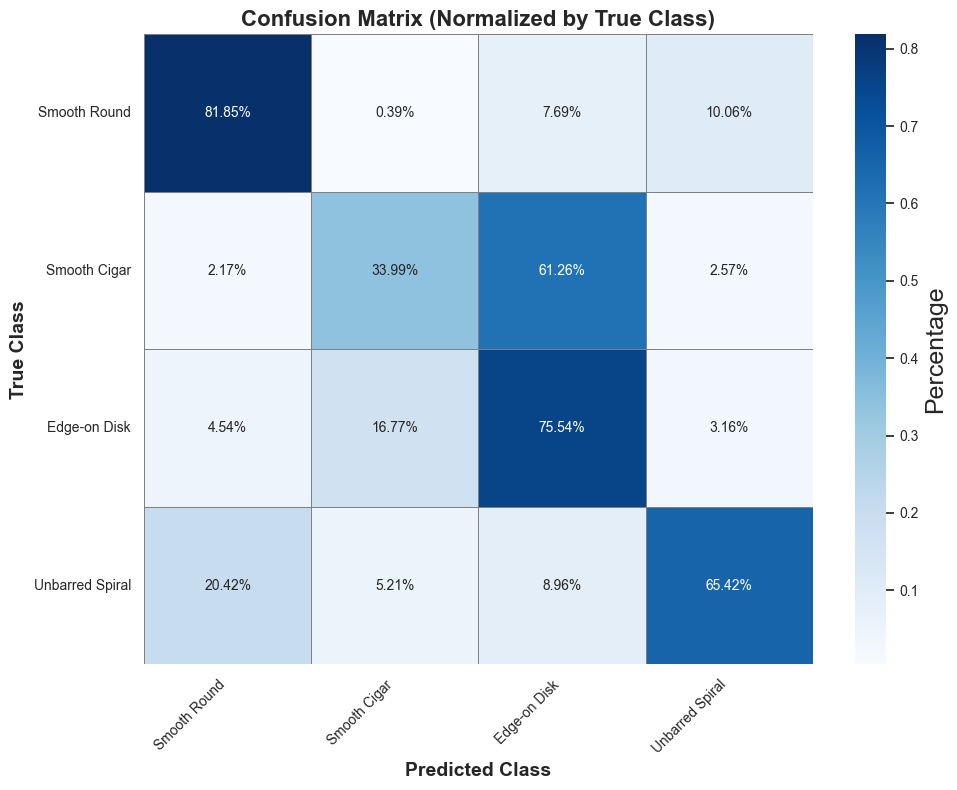


Confusion Matrix (Raw Counts):
True \ Pred    Smooth Round   Smooth Cigar   Edge-on Disk   Unbarred Spi   
---------------------------------------------------------------------------
Smooth Round   415            2              39             51             
Smooth Cigar   11             172            310            13             
Edge-on Disk   23             85             383            16             
Unbarred Spi   98             25             43             314            

Per-Class Accuracy:
  Smooth Round: 81.85%
  Smooth Cigar: 33.99%
  Edge-on Disk: 75.54%
  Unbarred Spiral: 65.42%

Overall Test Accuracy: 0.6420 (64.20%)


In [21]:
# Compute confusion matrix
true_labels = torch.argmax(y_test_onehot, dim=1).numpy()
pred_labels = np.array(all_preds)

cm = confusion_matrix(true_labels, pred_labels)

# Normalize confusion matrix by row (true labels) to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, 
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Class', fontsize=14, fontweight='bold')
plt.ylabel('True Class', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix (Normalized by True Class)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Also print the raw counts
print("\nConfusion Matrix (Raw Counts):")
print(f"{'True \\ Pred':<15}", end='')
for class_name in CLASS_NAMES:
    print(f"{class_name[:12]:<15}", end='')
print()
print("-" * 75)
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{class_name[:12]:<15}", end='')
    for j in range(len(CLASS_NAMES)):
        print(f"{cm[i, j]:<15}", end='')
    print()

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(CLASS_NAMES):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_accuracy:.2%}")
    
print(f"\nOverall Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

### 7. Interactive Galaxy Explorer GUI

This interactive visualization tool allows you to browse through the validation set and examine the 
model's predictions in real-time. The GUI displays each galaxy image using the Magma colormap 
(commonly used in astronomy visualization) alongside the model's softmax probability distribution
across all four classes.

Controls
--------
- **LEFT/RIGHT Arrow Keys:** Navigate through validation samples
- **R Key:** Jump to a random sample
- **M Key:** Toggle Magma colormap on/off
- **Q Key:** Quit the application

The visualization highlights the predicted class with a green bar, making it easy to spot correct 
classifications and identify failure cases where the model might confuse similar morphologies 
(e.g., smooth round vs. smooth cigar galaxies).

Assuming `pygame` is installed, if not, you can install it by creating a new code cell in your Jupyter notebook and running:
```bash
%pip install pygame
```

In [22]:
from model.gui import GalaxyExplorerGUI

In [25]:
# Ensure the model is in evaluation mode
model.eval()

# Instantiate the GUI
# x_val and y_val are the tensors we created from the GalaxyMNIST dataset
explorer = GalaxyExplorerGUI(
    model=model, 
    x_val=x_val, 
    y_val=y_val_onehot, 
    device=DEVICE
)
explorer.run()

ValueError: must be a valid 2d or 3d array


## 8. Export Model Weights for C/RISC-V Programs

Finally, we export the trained model parameters to files that can be loaded by C or RISC-V implementations. This enables deployment of the model on embedded systems or custom hardware accelerators without requiring a Python runtime.

The exporter utility serializes all weight matrices, biases, and S4 state space parameters to a format compatible with low-level implementations.

In [ ]:
export_model_parameters(model, "model_params")

# Save for other python programs (e.g., GUI)
torch.save(model.state_dict(), f"model_params/galaxys4{'-colored' if COLORED else ''}-{RNG_SEED}.pth")